In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt

#from pose_est import brute_force_pose_est
import postprocess_dataset
from utils import utils

In [19]:
# displays meshes at the predicted pose
def show_meshes_2(cfg, device, saved_model_path, only_show_instances=[], num_novel_view=3):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    
    # combining all cached predicted poses
    cached_pred_poses = {}
    pred_pose_paths = list(Path(output_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        cached_pred_poses = {**cached_pred_poses, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    print(processed_paths_dict)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)

                # rendering original and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
                mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
                mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)
                
                # rendering processed mesh at poses other than the predicted pose
                novel_view_renders = []
                for i in range(num_novel_view):
                    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim+ ((i+1)*45))
                    novel_view_renders.append(utils.render_mesh(mesh_processed, R, T, device))

                # visualizing
                print(processed_mesh_path)
                fig, ax = plt.subplots(nrows=1, ncols=3+num_novel_view, squeeze=False, figsize=(15,5))
                ax[0][0].imshow(input_image)
                ax[0][0].xaxis.set_visible(False)
                ax[0][0].yaxis.set_visible(False)

                ax[0][1].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
                ax[0][1].xaxis.set_visible(False)
                ax[0][1].yaxis.set_visible(False)

                ax[0][2].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
                ax[0][2].xaxis.set_visible(False)
                ax[0][2].yaxis.set_visible(False)
                
                for i in range(num_novel_view):
                    ax[0][2+i+1].imshow(novel_view_renders[i][0, ..., :3].cpu().numpy())
                    ax[0][2+i+1].xaxis.set_visible(False)
                    ax[0][2+i+1].yaxis.set_visible(False)
                plt.pause(0.05)

In [4]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, exp_name):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    output_dir = "{}_{}".format(input_dir_mesh, exp_name)
    print(output_dir)
    
    # combining all cached predicted poses
    cached_pred_poses = {}
    pred_pose_paths = list(Path(output_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        cached_pred_poses = {**cached_pred_poses, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(output_dir).rglob('*.obj'))
    processed_paths_dict = {str(path).split('/')[-1][:-4]:str(path) for path in processed_paths}
   
    
    for instance_name in cached_pred_poses:
        input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
        with torch.no_grad():
            mesh_original = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
            mesh_processed = utils.load_untextured_mesh(processed_paths_dict[instance_name], device)

        # rendering original and processed mesh at predicted pose
        pred_dist = cached_pred_poses[instance_name]['dist']
        pred_elev = cached_pred_poses[instance_name]['elev']
        pred_azim = cached_pred_poses[instance_name]['azim']
        R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
        mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
        mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)

        # visualizing
        print(instance_name)
        fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
        ax[0][0].imshow(input_image)
        ax[0][0].xaxis.set_visible(False)
        ax[0][0].yaxis.set_visible(False)

        ax[0][1].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
        ax[0][1].xaxis.set_visible(False)
        ax[0][1].yaxis.set_visible(False)

        ax[0][2].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
        ax[0][2].xaxis.set_visible(False)
        ax[0][2].yaxis.set_visible(False)
        plt.pause(0.05)

In [5]:
# python postprocess_dataset.py configs/testing.yaml --recompute_meshes
cfg_path = "configs/testing.yaml"
gpu_num = 0
exp_name = "processed"

cfg = utils.load_config(cfg_path, "configs/default.yaml")
device = torch.device("cuda:"+str(gpu_num))

{'0001old': [PosixPath('data/test_dataset_one_processed/batch_1_of_1/0001old.obj')]}
data/test_dataset_one_processed/batch_1_of_1/0001old.obj


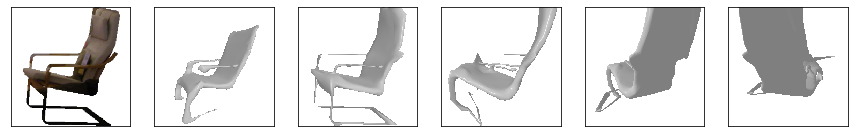

In [60]:
# show postprocessed meshes at predicted angle
show_meshes_2(cfg, device, cfg['dataset']['input_dir_mesh']+"_{}".format(exp_name))
#show_meshes_2(cfg, device, cfg['dataset']['input_dir_mesh']+"_{}/batch_1_of_1".format(exp_name))

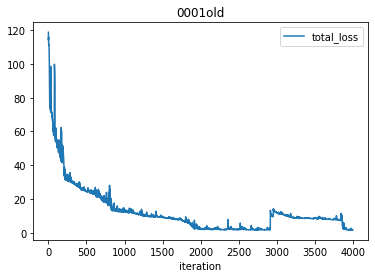

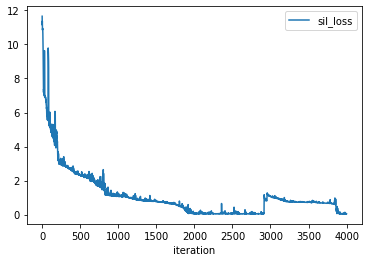

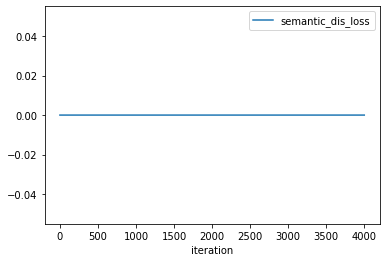

In [61]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        loss_info.plot.line(x='iteration', y='semantic_dis_loss')